In [1]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('INFO')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy as cgi
from cgi_phasec_poppy import misc

from wfsc import iefc_2dm as iefc
from wfsc import utils

dm_dir = cgi.data_dir/'dm-acts'

dm1_flat = 2*fits.getdata(dm_dir/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(dm_dir/'flatmaps'/'hlc_flattened_dm2.fits')

# dm1_flat = fits.getdata(cgi.dm_dir/'flatmaps'/'hlc_flattened_with_pattern_dm1.fits')
# dm2_flat = fits.getdata(cgi.dm_dir/'flatmaps'/'hlc_flattened_with_pattern_dm2.fits')

INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


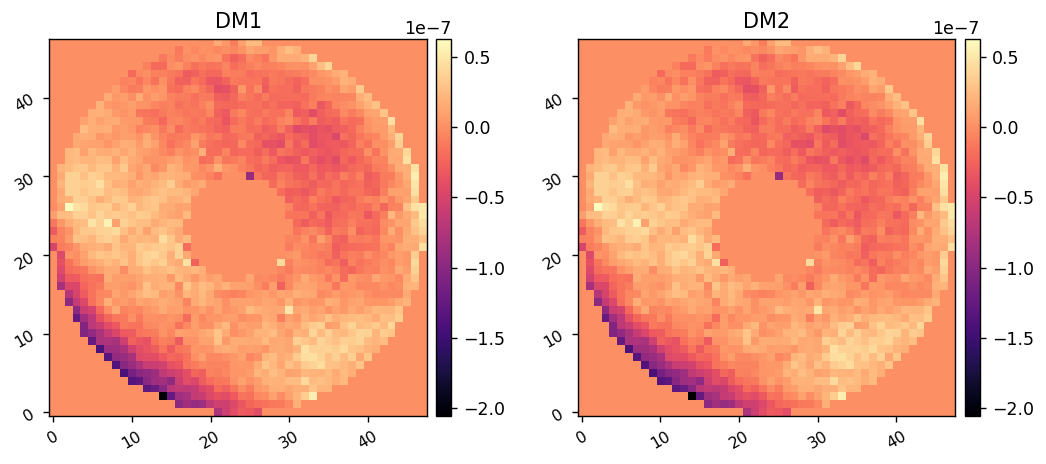

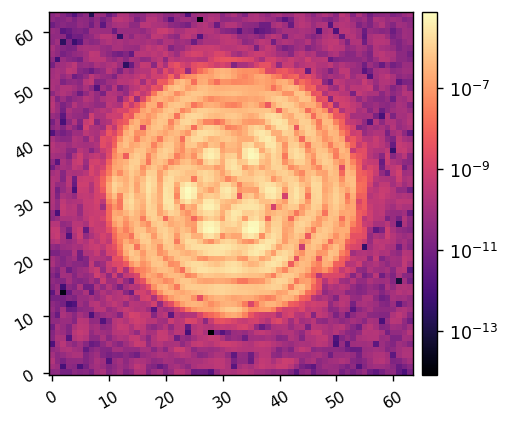

In [2]:
reload(cgi)
sysi = cgi.CGI(cgi_mode='hlc', 
              use_fpm=True,
              use_pupil_defocus=False, 
              polaxis=0,
              use_opds=True,
              dm1_ref=dm1_flat, dm2_ref=dm2_flat,
             )
sysi.show_dms()

npsf = sysi.npsf
Nact = sysi.Nact

ref_psf = sysi.snap()

misc.myimshow(ref_psf, lognorm=True)

# Create dark hole ROI to calibrate and control

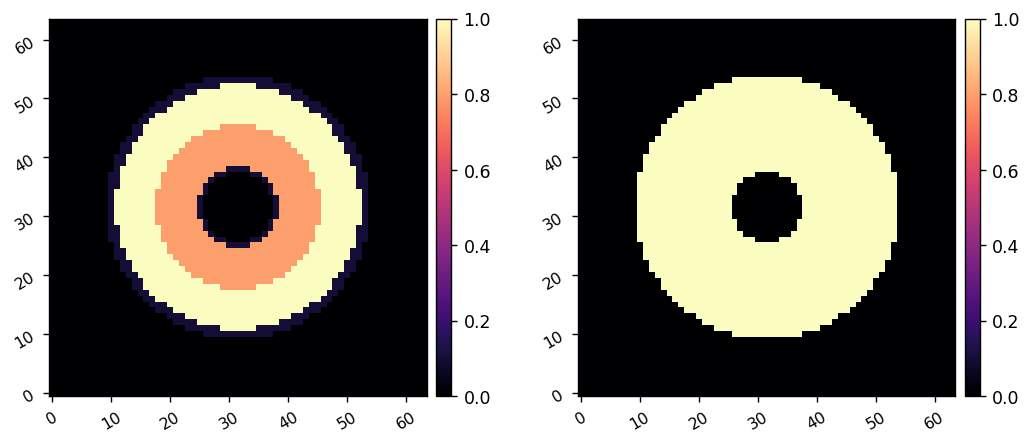

In [6]:
reload(utils)
xfp = (np.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*sysi.psf_pixelscale_lamD
fpx,fpy = np.meshgrid(xfp,xfp)
fpr = np.sqrt(fpx**2 + fpy**2)
    
iwa = 2.5
owa = 9.7
regions = [iwa, 3, 6, 9, owa]
weights = [0.1, 0.8, 1, 0.1]
weight_map = np.zeros((sysi.npsf,sysi.npsf), dtype=np.float64)
for i in range(len(weights)):
    roi_params = {
        'inner_radius' : regions[i],
        'outer_radius' : regions[i+1],
        'edge_position' : 0,
        'rotation':0,
        'full':True,
    }
    roi = utils.create_annular_focal_plane_mask(fpx, fpy, roi_params)
    weight_map += roi*weights[i]

control_mask = weight_map>0
misc.myimshow2(weight_map, control_mask)

# Create probe and fourier modes

(520, 2304) (260, 2)


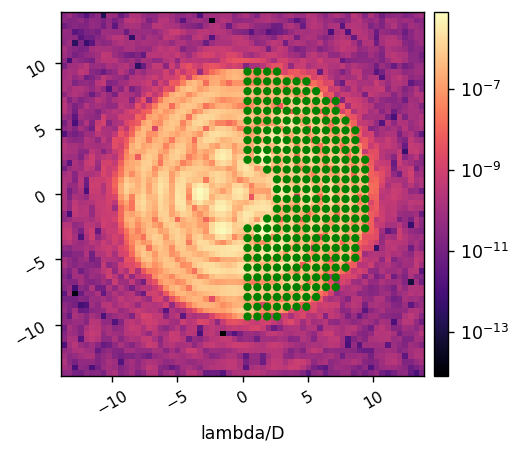

In [8]:
reload(utils)
calib_modes, fs = utils.select_fourier_modes(sysi, control_mask*(fpx>0), fourier_sampling=0.75) 
nmodes = calib_modes.shape[0]
print(calib_modes.shape, fs.shape)

patches = []
for f in fs:
    center = (f[0], f[1])
    radius = 0.25
    patches.append(Circle(center, radius, fill=True, color='g'))
    
misc.myimshow(ref_psf, lognorm=True, pxscl=sysi.psf_pixelscale_lamD, patches=patches)

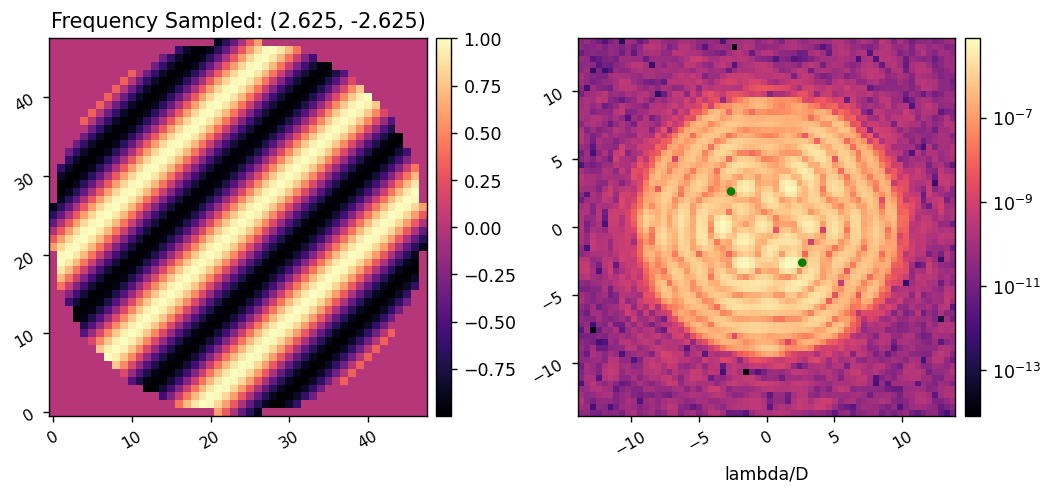

In [11]:
import time
for i in range(calib_modes.shape[0]//2):
    try:
        misc.myimshow2(calib_modes[i].reshape(Nact,Nact), ref_psf, 
                       'Frequency Sampled: ({:.3f}, {:.3f})'.format(fs[i][0], fs[i][1]),
                       lognorm2=True,
                       pxscl2=sysi.psf_pixelscale_lamD, 
                       patches2=[Circle(fs[i], 0.25, fill=True, color='g'),
                                 Circle(-fs[i], 0.25, fill=True, color='g')])
        clear_output(wait=True)
        time.sleep(0.25)
    except KeyboardInterrupt:
        break

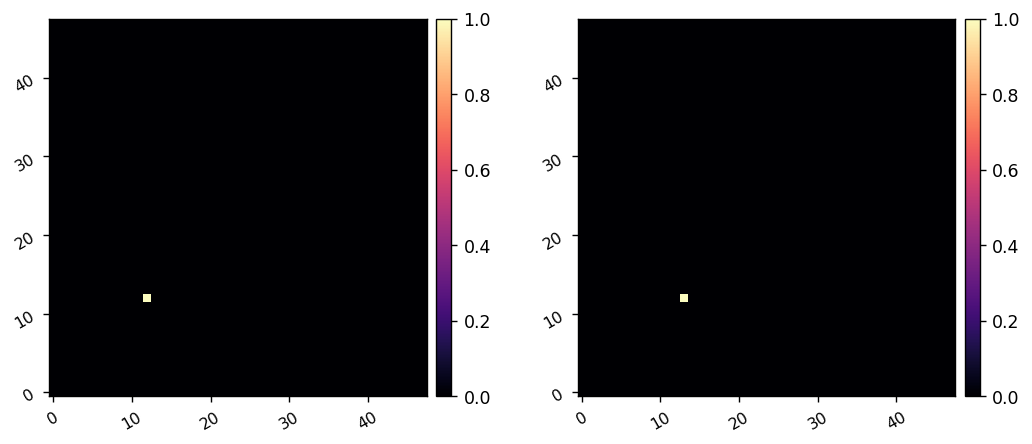

In [12]:
reload(iefc)
probe_modes = utils.create_probe_poke_modes(Nact, xinds=[Nact//4, Nact//4+1], yinds=[Nact//4, Nact//4], display=True)
# probe_modes = utils.create_fourier_probes(calib_modes, display_probes=True)

In [18]:
probe_amp = 3e-8
calib_amp = 5e-9

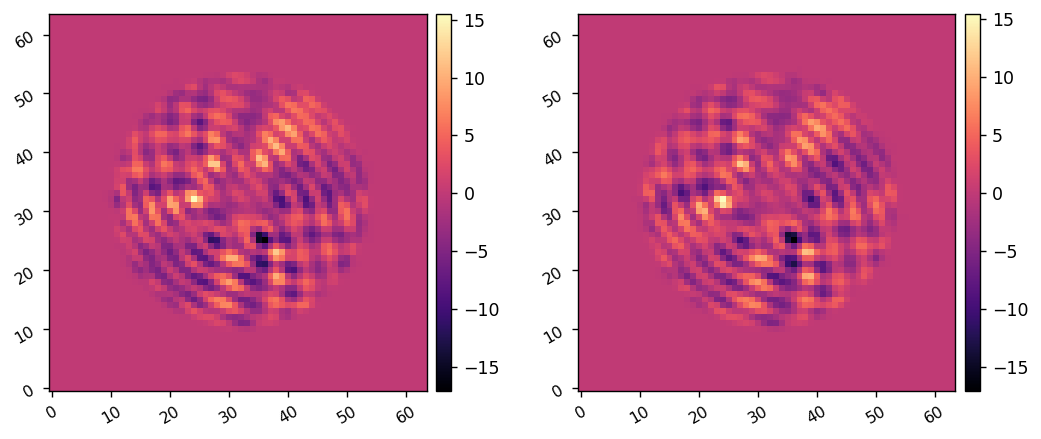

In [19]:
reload(iefc)
sysi.reset_dms()
differential_images, single_images = iefc.take_measurement(sysi, 
                                                           probe_modes, probe_amp, 
                                                           return_all=True, display=True)

# Calibrate IEFC (or load in previous calibration data)

In [20]:
reload(iefc)
sysi.reset_dms()
response_cube, calibration_cube = iefc.calibrate(sysi, 
                                                 probe_amp, probe_modes, 
                                                 calib_amp, calib_modes)

Calibrating I-EFC...
Calibration interrupted.
Calibration complete.


In [33]:
fname = 'hlc_2dm_annular_39'
# iefc_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')
iefc_dir = Path('C:/Users/Kian/Documents/data-files/roman-cgi-iefc-data')

(282, 3, 4096)

In [14]:
misc.save_pickle(iefc_dir/'response-data'/fname, response_cube)
misc.save_pickle(iefc_dir/'calibration-data'/fname, calibration_cube)

Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/response-data/hlc_2dm_annular_36
Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/calibration-data/hlc_2dm_annular_36


In [15]:
response_cube = misc.load_pickle(iefc_dir/'response-data'/fname)
calibration_cube = misc.load_pickle(iefc_dir/'calibration-data'/fname)

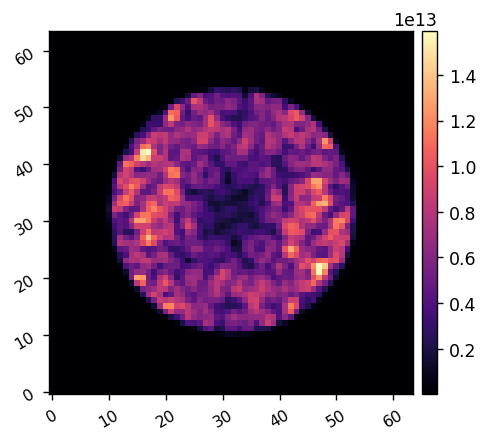

In [34]:
response_sum = np.sum(abs(response_cube), axis=(0,1))
misc.myimshow(response_sum.reshape(64,64))

# Create control matrix

In [21]:
reload(iefc)

reg_fun = iefc.construct_control_matrix
reg_conds = [[0, 10, 15, 20],
             [(1e-1, 1e-1), (1e-3, 1e-3), (1e-1, 1e-1), (1e-2, 1e-2)]]

# Run IEFC

In [38]:
reload(iefc)

sysi.reset_dms()

images, dm1_commands, dm2_commands = iefc.run(sysi, 
                                              reg_fun,reg_conds,
                                              response_cube, 
                                              probe_modes, 
                                              probe_amplitude, 
                                              calibration_modes, 
                                              weights, 
                                              num_iterations=50, 
                                              loop_gain=0.1, leakage=0.0,
                                              display_all=True,
                                             )

Running I-EFC...
	Closed-loop iteration 1 / 10


ValueError: shapes (2304,282) and (0,) not aligned: 282 (dim 1) != 0 (dim 0)

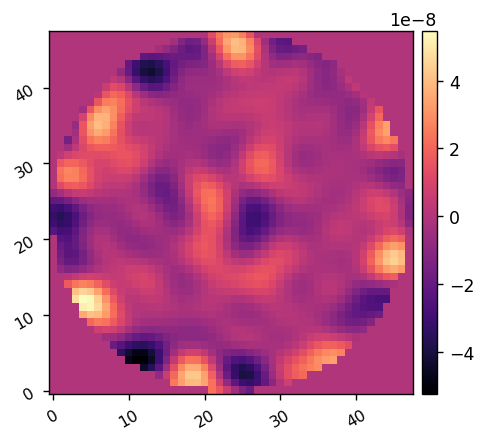

In [19]:
dm1 = hlc.get_dm1()

misc.myimshow(dm1-dm1_flat)

In [163]:
iefcu.save_pickle(data_dir/'image-results'/fname, images)
iefcu.save_pickle(data_dir/'dm-results'/fname, dm_commands)

Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/image-results/dshaped_Yopds_polaxis0_iwa3.0_owa6.0
Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/dm-results/dshaped_Yopds_polaxis0_iwa3.0_owa6.0
